## Unzip art image file

In [ ]:
# !unzip -q "/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/Art_Image_dataset.zip" -d "/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/Art_Image_dataset"

---

## Import Libraries

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
from keras import Sequential
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, LeakyReLU, Flatten, Dropout, Reshape
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import glob
%matplotlib inline


---
## 11.1 Prepare Image Data (Real, Fake)

### 11.1.1 Prepare Real Image

In [109]:
# 1.  List all filename in art image path
img_size = (32, 32, 3)
filenames = glob.glob('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/Art_Image_dataset/Art_Bangkok/WaterColor/*.jpg')
train_dataset = []

In [121]:
for i in range(len(filenames)):
  resized = image.load_img(filenames[i], target_size=img_size, interpolation='bilinear')
  img = image.img_to_array(resized, dtype="uint8")
  img = img / 255
  # img = (img - 0.5) * 2
  train_dataset.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

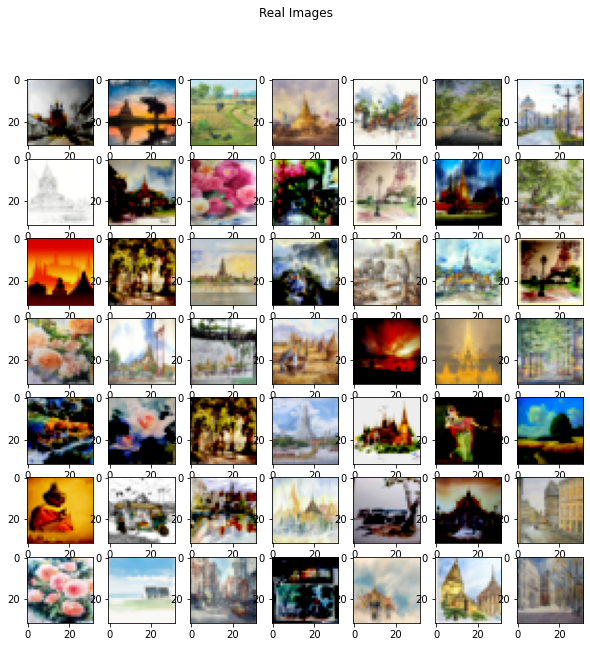

In [122]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle("Real Images")
rows = 7
columns = 7

# 2. Random selected images
def generate_real_samples(dataset, n_samples):
  h, w, c = img_size
  x = np.empty((n_samples, h, w, c))
  ix = np.random.randint(0, len(dataset), n_samples)
  for i in range(len(ix)):
    x[i] = (dataset[ix[i]])
  y = np.ones((n_samples,1))
  return x, y

# 3. Dispaly random real image
x_real, y_real = generate_real_samples(train_dataset, 150)

for i in range(49):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(x_real[i])
plt.show()

In [123]:
print('x min:', np.min(train_dataset))
print('x max:', np.max(train_dataset))
print('x.shape:', x_real.shape)
print('y.shape:', y_real.shape)

x min: -1.0
x max: 1.0
x.shape: (150, 32, 32, 3)
y.shape: (150, 1)


### 11.1.2 Prepare Fake Image initial for training discriminator(D)

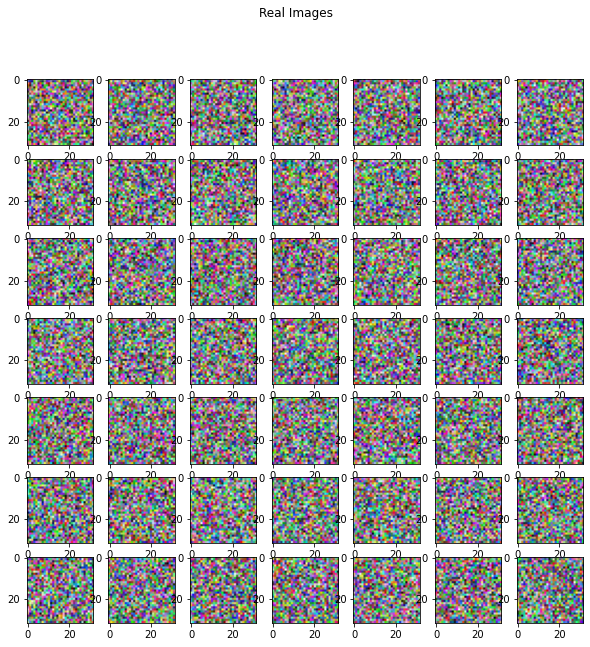

In [124]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle("Real Images")
rows = 7
columns = 7

datagen = ImageDataGenerator(rescale=1./255)

# 1. Fake image
def generate_fake_samples(n_samples, target_size=(32,32,3)):
  h,w,c = target_size
  x = np.random.rand(n_samples, h, w, 3)
  x = x / 1
  # x = (x - 0.5) * 2
  x = x.reshape(n_samples, h, w, c)
  y = np.zeros((n_samples,1))
  return x, y

# 2. Generate fake image sample
x_fake, y_fake = generate_fake_samples(150, target_size=img_size)

for i in range(49):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(x_fake[i], cmap='gray')
plt.show()

In [125]:
print('min:', np.min(x_fake))
print('max:', np.max(x_fake))
print('x.shape:', x_real.shape)
print('y.shape:', y_real.shape)

min: 7.761037652542768e-07
max: 0.9999961000213989
x.shape: (150, 32, 32, 3)
y.shape: (150, 1)


---
## 11.2 Prepare Discriminator, Generator Model

### 11.2.1 Create Discriminator Model (D) and Training

In [126]:
# 1. Discriminator Model
def define_discriminator(in_shape=(32,32,3)):
  # 1.1 Parameter
  nCCN_layer = 4
  CNN_L1 = 64
  CNN_L2 = 128
  CNN_L3 = 128
  CNN_L4 = 256
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  train_loss = 'binary_crossentropy'
  epoch = 60

  # 1.2 Model architecture
  model = Sequential()

  #normal
  model.add(Conv2D(CNN_L1, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))

  #downsample
  model.add(Conv2D(CNN_L2, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #downsample
  model.add(Conv2D(CNN_L3, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #downsample
  model.add(Conv2D(CNN_L4, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  #compile model
  model.compile(loss=train_loss, optimizer=opt, metrics=['accuracy'])

  return model


# 2. Train the discriminator model
def train_discriminator(model, dataset, n_iter=60, n_batch=128, target_size=(32,32,3)):
  half_batch = int(n_batch/2)

  #manually enumerate epochs
  for i in range(n_iter):
    #get randomly select real samples
    x_real, y_real = generate_real_samples(dataset, half_batch)

    #update discriminator on real smaples
    _, real_acc = model.train_on_batch(x_real, y_real)
    
    #generate fake examples
    x_fake, y_fake = generate_fake_samples(half_batch, target_size=img_size)

    #update discriminator on fake samples
    _, fake_acc = model.train_on_batch(x_fake, y_fake)

    #summarize performanace
    # print('real_acc:',real_acc, '\t fake_acc:', fake_acc)


# 3. Define model
d_model = define_discriminator(img_size)


# 4. summarize the model
d_model.summary()

# 5. Training Discriminator
train_discriminator(d_model, train_dataset, target_size=img_size)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_68 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_47 (Conv2D)          (None, 4, 4, 256)       

### 11.2.2 Create Generator Model (G)

In [127]:
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.core.reshape import Reshape
# 1. Define the combined generator and discriminator model, for updating the generator
def define_generator(latent_dim, discr_out=(256,4,4)):
  # 1.1. Parameter
  nCNN_layer = 4
  CNN_L1 = 128
  CNN_L2 = 128
  CNN_L3 = 128
  CNN_L4 = 3 #channels

  # 1.2 Model Architecture
  model = Sequential()

  #foundation for 4x4 image
  c, w, h = discr_out
  n_nodes = c * w * h

  model.add(Dense(n_nodes, input_shape=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((w, h, c)))

  #upsample to 8x8
  model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #upsample to 16x16
  model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #upsample to 32x32
  model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  
  return model


#2. Define the generator model
g_model = define_generator(latent_dim=(100,))


#3. summarize the model
g_model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 4096)              413696    
                                                                 
 leaky_re_lu_72 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_8 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 8, 8, 128)        524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_73 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                          

---
## 11.3 GAN Training and Prediction

### 11.3.1 Create GAN Model (G, D) and Training

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_40 (Sequential)  (None, 32, 32, 3)         1466115   
                                                                 
 sequential_39 (Sequential)  (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


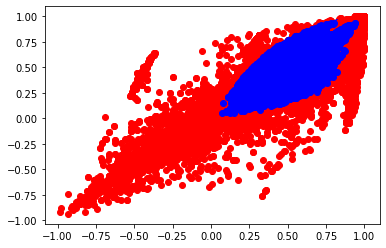

In [132]:
EP = 50

# 1. Define the combined generator and discriminator model for updating the generator
def define_gan(g_model, d_model):
  # make weights in discriminator not trainable
  d_model.trainable = False

  #connect them
  model = Sequential()

  #add generator
  model.add(g_model)

  #add discriminator
  model.add(d_model)

  #compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


#
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.normal(0, 1, (n_samples, latent_dim))
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


# 2. Update generator fake image using generator prediction
# use the generator to generate n fake examples with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  #generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)

  #predict outputs
  x = g_model.predict(x_input)

  #create fake class labels 0
  y = np.zeros((n_samples))
  return x, y


# 3. Train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=EP, n_batch=128):
  batch_per_epo = int(len(dataset)/n_batch)  
  half_batch = int(n_batch/2)

  #manually enumerate epochs
  for i in range(n_epochs):
    #enumerate batches over the training set
    for j in range(batch_per_epo):
      #get randomly selected 'real' samples
      x_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(x_real, y_real)

      #generate 'fake' examples
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)

      #prepare points in latent space as input for the generator
      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      # print(x_gan)
      # print(y_gan)

      #update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(x_gan, y_gan)

      # print(d_loss1, d_loss2, g_loss)

      #evaluate the model perfomance every n_epochs
      if (i+1) % n_epochs == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)


# 4.
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  #prepare 'real' samples
  x_real, y_real = generate_real_samples(dataset, n_samples)

  #evaluate discriminator on 'real' examples
  _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)

  #prepare 'fake' samples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

  ##evaluate discriminator on 'fake' examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

  #summarize discriminator performance
  # print(acc_real, acc_fake)

  #save plot
  # print ("Data comparison after {} epochs".format(epoch+1))
  # print()
  # print("Accuracy for the real data: {}, Accuracy for the fake data: {}".format(acc_real, acc_fake))
  # print()
  plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
  plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
  plotname = 'plot_%03d.png' % (epoch+1)
  plt.savefig(plotname)
  # plt.show()
  # print()

  #save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  # g_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
  g_model.save(filename)


# 5. Create the GAN
gan_model = define_gan(g_model, d_model)

# summarize gan model
gan_model.summary()


# 6. Train model
train(g_model, d_model, gan_model, train_dataset, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

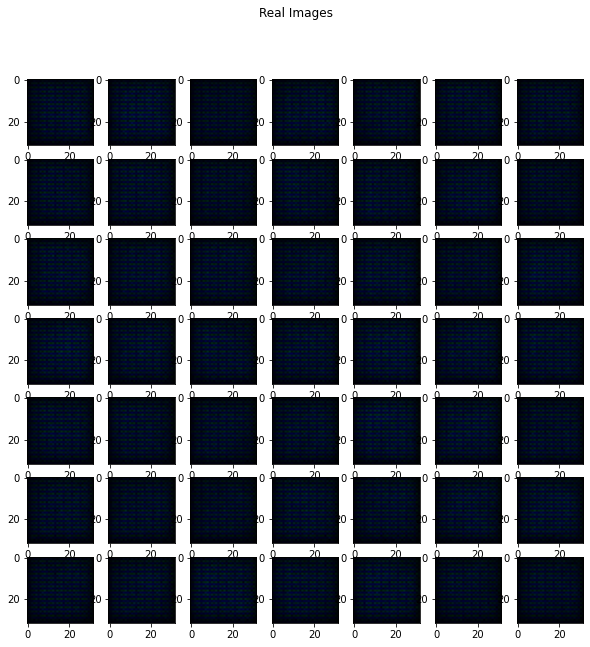

In [134]:
from keras.models import load_model

fig = plt.figure(figsize=(10, 10))
fig.suptitle("Real Images")
rows = 7
columns = 7

model = load_model('/content/generator_model_020.h5')

x, _ = generate_fake_samples(model, 100, 150)

for i in range(49):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(x[i])
plt.show()